In [2]:
import os
import pandas as pd
import numpy as np

# --- Configuration ---
# Update this path to your final embedding dataset on your local machine
DATA_DIR = "data"
FINAL_EMBEDDING_CSV = os.path.join(DATA_DIR, "final_dataset_with_embeddings.csv")

# --- Load Data ---
print(f"Loading data from '{FINAL_EMBEDDING_CSV}'...")
df = pd.read_csv(FINAL_EMBEDDING_CSV)

# Separate the data into features (X), labels (y), and metadata
embedding_cols = [col for col in df.columns if col.startswith('emb_')]
X = df[embedding_cols].values
y = df['is_bug_introducing'].values
metadata_df = df.drop(columns=embedding_cols + ['is_bug_introducing'])

print(f"Data loaded successfully. Found {X.shape[0]} samples with {X.shape[1]} embedding dimensions.")

Loading data from 'data\final_dataset_with_embeddings.csv'...
Data loaded successfully. Found 12595 samples with 768 embedding dimensions.


In [ ]:
from sklearn.preprocessing import Normalizer

print("Normalizing embedding vectors...")
normalizer = Normalizer(norm='l2')
X_normalized = normalizer.fit_transform(X)

print("Vectors normalized successfully.")

Normalizing embedding vectors...
Vectors normalized successfully.


Number of components needed to explain 95% of the variance: 177


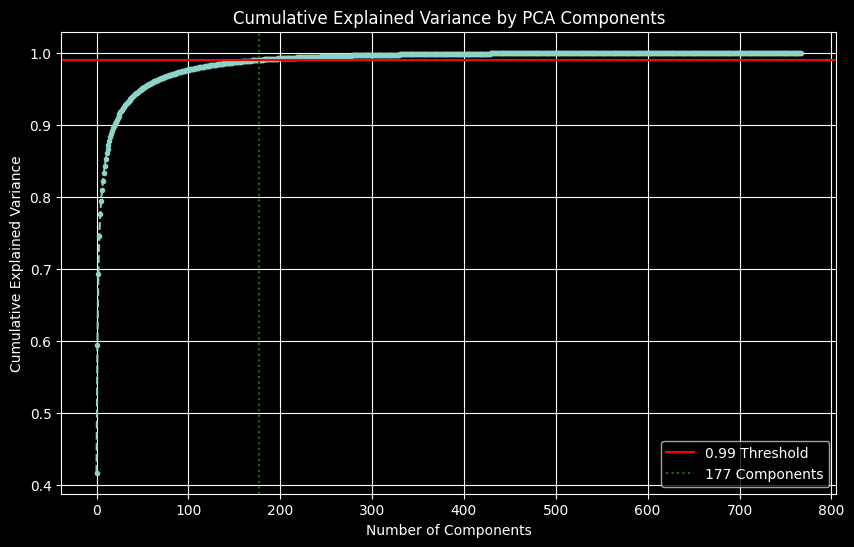

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

#already X_normalized data from the previous step
THRESHOLD = 0.99

# 1. Run PCA keeping all components
pca_full = PCA(n_components=None)
pca_full.fit(X_normalized)

# 2. Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# 3. Find the number of components to explain % of the variance
n_components_Threshold = np.argmax(cumulative_variance >= THRESHOLD) + 1

print(f"Number of components needed to explain {THRESHOLD*100}% of the variance: {n_components_Threshold}")

# 4. Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='.', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

# Add a line for the threshold
plt.axhline(y=THRESHOLD, color='r', linestyle='-', label=f'{THRESHOLD} Threshold')
plt.axvline(x=n_components_Threshold, color='g', linestyle=':', label=f'{n_components_Threshold} Components')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

print(f"Performing PCA to reduce dimensions to {n_components_Threshold}...")
pca = PCA(n_components=n_components_Threshold, random_state=42)
X_pca = pca.fit_transform(X_normalized)

# Create a new DataFrame for visualization
df_pca = pd.DataFrame(X_pca, columns=[f'pca_{i+1}' for i in range(n_components_Threshold)])
df_pca['is_bug'] = y # Add the labels for coloring
df_pca['commit_hash'] = metadata_df['commit_hash']

print("PCA complete. Here are the first few rows of the new DataFrame:")
display(df_pca.head())

Performing PCA to reduce dimensions to 51...
PCA complete. Here are the first few rows of the new DataFrame:


,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_170,pca_171,pca_172,pca_173,pca_174,pca_175,pca_176,pca_177,is_bug,commit_hash
0,0.009118,-0.015695,-0.034960,-0.040453,-0.003473,-0.008147,-0.016861,0.009553,0.001948,0.001620,...,-0.002215,-0.001279,0.000714,0.000800,0.000997,-0.000534,-0.000106,0.000822,1,e620a8b1cd55f8caddd293b9b9547aba32d78a7b
1,0.008974,-0.023083,-0.034835,-0.042251,-0.001708,-0.018825,-0.013937,0.013918,0.005601,-0.002535,...,-0.001635,-0.001969,0.000137,-0.000442,0.000871,0.000066,-0.000860,0.000665,0,ead4427d98ed9589d13c49912707465f7788a736
2,0.008283,0.020001,-0.043838,-0.001172,-0.008543,0.003286,0.002809,0.005302,-0.013274,-0.013967,...,0.000194,0.000063,-0.000991,-0.000066,0.000402,-0.001682,0.001189,0.001050,1,966fad564f08911b4eb145e2d7a049c9f40aed74
3,0.008272,0.004637,0.008009,-0.024884,-0.006403,0.008944,0.001881,-0.011631,-0.014782,0.019653,...,0.001040,0.001971,0.000207,0.000460,-0.000897,-0.001386,-0.000135,0.000797,0,f65e79949d8f6e2316a60b20a126ece88f6ce3cb
4,0.009267,-0.003316,-0.006289,0.005594,0.010054,-0.025736,0.010938,0.024097,0.005805,-0.014185,...,-0.001939,0.002116,0.000743,0.001912,-0.001053,-0.001087,0.001594,0.002201,1,ec0ad0baca52b88c77d7d63760b6e82f4b0a8fd3


Splitting data into training and testing sets...
Training set size: 10076
Test set size: 2519

Training XGBoost classifier...


c:\Users\pradishan\code\wso2-AI-Tool\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [11:34:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training complete.

Evaluating the model on the test set...
Accuracy: 0.7380

Classification Report:
              precision    recall  f1-score   support

   Not a Bug       0.73      0.66      0.70      1143
         Bug       0.74      0.80      0.77      1376

    accuracy                           0.74      2519
   macro avg       0.74      0.73      0.73      2519
weighted avg       0.74      0.74      0.74      2519


Generating confusion matrix...


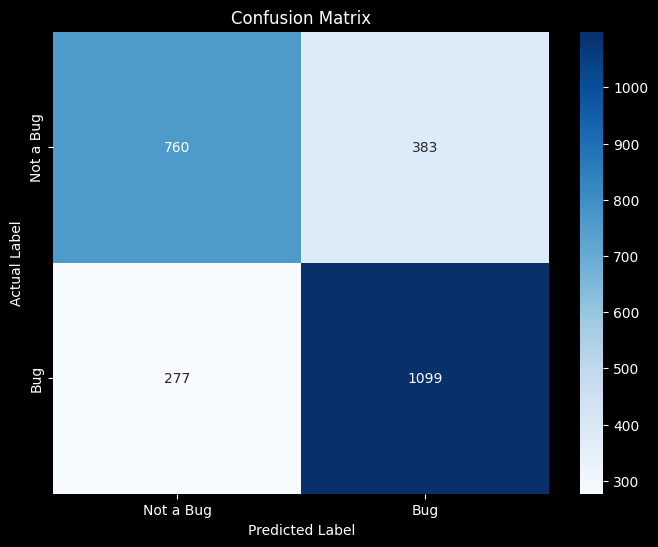

In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

import matplotlib.pyplot as plt

# --- Split Data into Training and Testing Sets ---
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# --- Train XGBoost Classifier ---
print("\nTraining XGBoost classifier...")
# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_classifier.fit(X_train, y_train)
print("Training complete.")

# --- Evaluate the Model ---
print("\nEvaluating the model on the test set...")
# Make predictions on the test data
y_pred = xgb_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not a Bug', 'Bug']))

# --- Visualize the Confusion Matrix ---
print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not a Bug', 'Bug'], 
            yticklabels=['Not a Bug', 'Bug'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()